In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# read case
print(os.getcwd())
case = '00131'


D:\Promotion\neurolib\GUI\current\gui\data\shift_init\5


### Bistability

In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

#####################################################
def getclosest(k_, found_solution, exc, inh, already_tried_):
    import numpy as np
    if len(found_solution) == 0:
        print("no solutions found")
        return -1
    
    start_ind = -1
    for j_ in found_solution:
        if j_ not in already_tried_ and j_ != k_:
            start_ind = j_
            break
            
    if start_ind == -1:
        return -1
        
    min_dist = np.sqrt((exc[k_] - exc[start_ind])**2 + (inh[k_] - inh[start_ind])**2)
    min_i = start_ind
        
    print(found_solution, already_tried_)
        
    if len(found_solution) == len(already_tried_):
        print("already tried all options")
        min_i = -1
        return min_i
    
    for i_ in found_solution:
        if i_ not in already_tried_:
            if i_ != k_ and i_ != min_i:
                dist_ = np.sqrt((exc[k_] - exc[i_])**2 + (inh[k_] - inh[i_])**2)
                if dist_ < min_dist:
                    min_dist = dist_
                    min_i = i_
                    
    if min_i == 0 and 0 in already_tried_:
        return -1
    
    return min_i

In [4]:
##### LOAD BOUNDARIES
data_file = 'bi.pickle'
with open(data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))
#plt.scatter(exc, inh)

147


In [5]:
bestControl_init = [None] * len(exc)
bestState_init = [None] * len(exc)
cost_init = [None] * len(exc)
runtime_init = [None] * len(exc)
grad_init = [None] * len(exc)
phi_init = [None] * len(exc)
costnode_init = [None] * len(exc)
weights_init = [None] * len(exc)

conv_init = [[False]*2] * len(exc)

In [6]:
bestControl_0 = [None] * len(exc)
bestState_0 = [None] * len(exc)
cost_0 = [None] * len(exc)
runtime_0 = [None] * len(exc)
grad_0 = [None] * len(exc)
phi_0 = [None] * len(exc)
costnode_0 = [None] * len(exc)
weights_0 = [None] * len(exc)

conv_0 = [[False]*2] * len(exc)

In [7]:
bestControl_1 = [None] * len(exc)
bestState_1 = [None] * len(exc)
cost_1 = [None] * len(exc)
runtime_1 = [None] * len(exc)
grad_1 = [None] * len(exc)
phi_1 = [None] * len(exc)
costnode_1 = [None] * len(exc)
weights_1 = [None] * len(exc)

conv_1 = [[False]*2] * len(exc)

In [8]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ", None]

In [9]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

c_var = [ [0], [1], [0,1]]
p_var = [ [0], [0], [0]]

### CURRENTS
cntrl_vars_0 = [0,1]
prec_vars = [0]

if case[0] == '0':    # low to high
    max_I = [3., -3.]
elif case[0] == '1':
    max_I = [-3., 3.]
    
if case[1] == '0':    # sparsity
    factor_ws = 1.
    factor_we = 0.
elif case[1] == '1':  # energy
    factor_ws = 0.
    factor_we = 1.
    
if case[3] == '0':
    cntrl_vars_init = [0]
elif case[3] == '1':
    cntrl_vars_init = [1]
elif case[3] == '2':
    cntrl_vars_init = [0,1]
elif case[3] == '3':
    cntrl_vars_init = [0]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-3) + '0'
    read_file = os.path.join( os.getcwd()[:-12], case_read, 'control_init_' + case_read + '.pickle')
    print(read_file)
elif case[3] == '4':
    cntrl_vars_init = [1]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-3) + '0'
    read_file = os.path.join( os.getcwd()[:-12], case_read, 'control_init_' + case_read + '.pickle')
    print(read_file)
elif case[3] == '5':
    cntrl_vars_init = [0,1]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-3) + '0'
    read_file = os.path.join( os.getcwd()[:-12], case_read, 'control_init_' + case_read + '.pickle')
    print(read_file)

if case[4] == '0':
    dur = 100
    trans_time = 0.8
elif case[4] == '1':
    dur = 400
    trans_time = 0.95
    
maxC = [5., -5., 0.18, 0.]

n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

D:\Promotion\neurolib\GUI\current\gui\data\00100\control_init_00100.pickle


In [10]:
init_file = 'control_init_' + case + '.pickle'
final_file = 'control_' + case + '.pickle'
case_1 = case[0] + case[1] + '0' + case[3] + case[4]
final_file_1 = 'control_' + case_1 + '.pickle'

In [11]:
if os.path.isfile(init_file) :
    print("file found")
    
    with open(init_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_init = load_array[0]
    bestState_init = load_array[1]
    cost_init = load_array[2]
    runtime_init = load_array[3]
    grad_init = load_array[4]
    phi_init = load_array[5]
    costnode_init = load_array[6]
    weights_init = load_array[7]

In [12]:
# get initial parameters and target states

i_range = [20, 35, 50, 65, 80]
i_range_0 = i_range
i_range_1 = i_range
data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    
    aln.params.duration = dur

    target[i] = aln.getZeroTarget()
    target[i][:,0,:] = target_rates[0]
    target[i][:,1,:] = target_rates[1]

-------  20 0.4500000000000001 0.4750000000000002
-------  35 0.5500000000000003 0.5250000000000002
-------  50 0.47500000000000014 0.6000000000000003
-------  65 0.5000000000000002 0.6500000000000004
-------  80 0.5250000000000001 0.7000000000000004


In [13]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
    cost.setParams(1.0, 0.0, 0.0)

##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, costnode_init_ = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12738.116450271265
Gradient descend method:  None
RUN  0 , total integrated cost =  12738.116450271265
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  35 0.5500000000000003 0.5250000000000002
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  30546.428984237715
Gradient descend method:  None
RUN  0 , total integrated cost =  30546.428984237715
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15942.955436075114
Gradient descend method:  None
RUN  0 , total integrated cost =  15942.955436075114
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  65 0.5000000000000002 0.650000000

In [19]:
factor_iteration = 20.
aln.params.duration = dur
shift = 2500

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
        
    ##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    
    if conv_init[i] == [True, True]:
    
        with open(read_file,'rb') as f:
            load_array = pickle.load(f)

        bestControl_read = load_array[0]

        bestControl_init[i] = np.zeros(( 1, 6, n_dur + n_pre + n_post -2 ))
        bestControl_init[i][:,:,n_pre-1+shift:n_pre-1+shift+1000] = bestControl_read[i][:,:,n_pre-1:n_pre-1+1000].copy()
        weights_init = load_array[7]
        
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]       
        cost.setParams(weights_init[i][0], weights_init[i][1], weights_init[i][2])
        
        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = 0, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        continue
    
    
    
    if not type(bestControl_init[i]) == type(None):
        continue
        
    control0 = aln.getZeroControl()

    ##### initial guess
    weight_ = 10
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(100 * factor_iteration)

    weights_init[i] = cost.getParams()

    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    j = 1
    while cost_init[i][-j] == 0.:
        j += 1
    
    weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
    print("weight = ", weight_)
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)
    control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(500 * factor_iteration)

    weights_init[i] = cost.getParams()
    
    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
        
    with open(init_file,'wb') as f:
        pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                 costnode_init, weights_init], f)

with open(init_file,'wb') as f:
        pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                 costnode_init, weights_init], f)

-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 3213.823272271244
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12651.53264851801
Gradient descend method:  None
RUN  0 , total integrated cost =  12651.53264851801
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  35 0.5500000000000003 0.5250000000000002
set cost params:  1.0 0.0 48505.092678435896
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  30102.525587085234
Gradient descend method:  None
RUN  0 , total integrated cost =  30102.525587085234
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  1.0 0.0 2977.1926200199127
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15854.506476970417
Gradient descend method:  None
RUN  0 , total integrated cost =  15854.506476970417
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


--------- 20


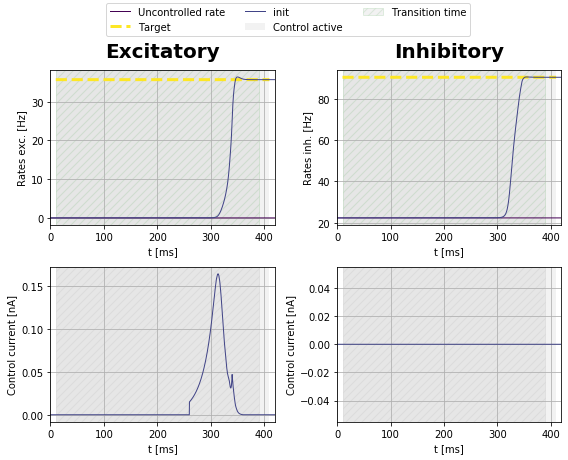

--------- 35


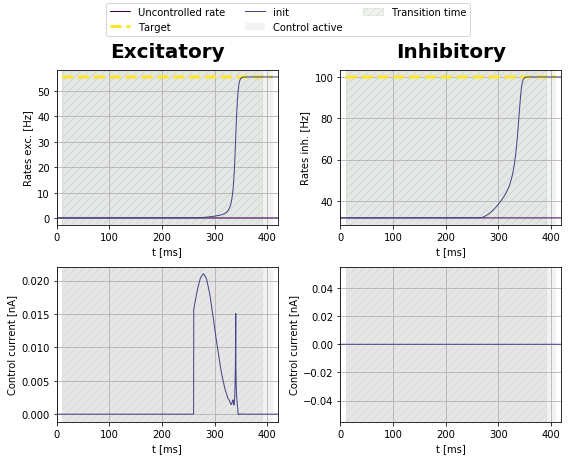

--------- 50


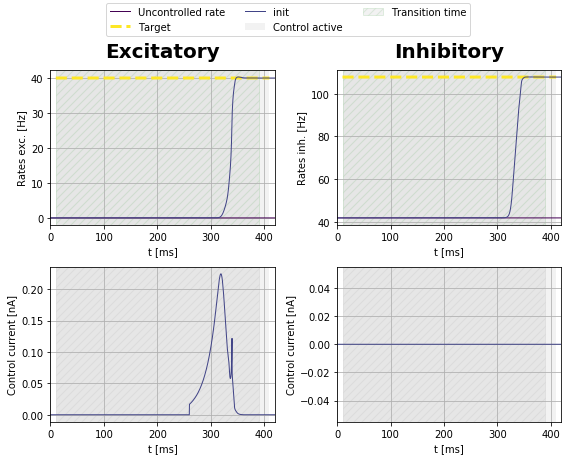

--------- 65


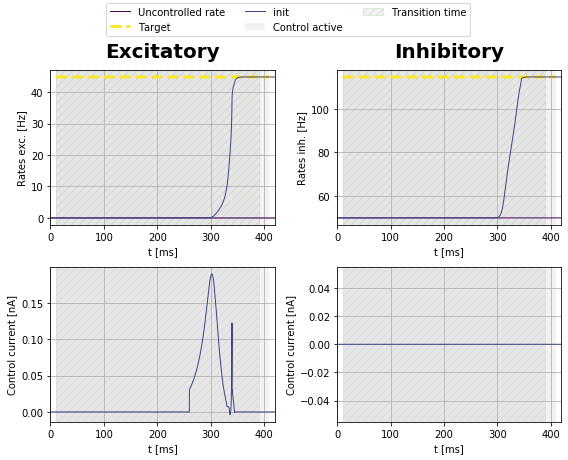

--------- 80


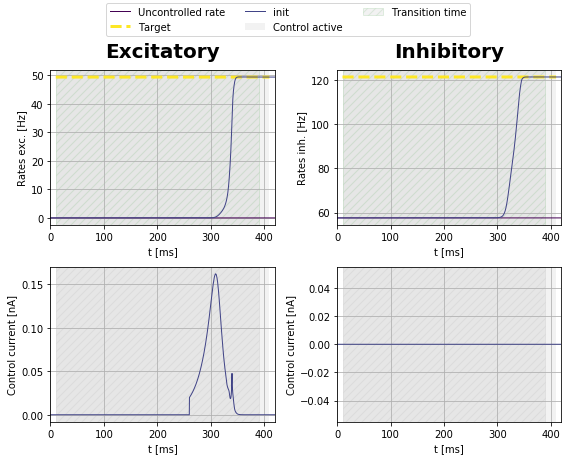

In [20]:

#plot initial guesses
for i in i_range:
    print("---------", i)
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i]],
        [costnode_init[i]], [weights_init[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()


In [21]:
found_solution = []
no_solution = []
factor_iteration = 20.

for i in i_range:
    print("------- ", i, exc[i], inh[i])    

    if np.abs(np.mean(bestState_init[i][0,0,-300:]) - target[i][0,0,-1]) < 0.1 * np.abs(
        np.mean(bestState_init[i][0,0,-100:]) - bestState_init[i][0,0,0]) and np.abs(
        np.mean(bestState_init[i][0,1,-300:]) - target[i][0,1,-1]) < 0.1 * np.abs(
        np.mean(bestState_init[i][0,1,-100:]) - bestState_init[i][0,1,0]) and np.amax(
        bestState_init[i][0,0,:]) < target[i][0,0,-1] + 5. and np.amax(
        bestState_init[i][0,1,:]) < target[i][0,1,-1] + 5.:
        # and np.amin(bestState_init[i][0,0,:]) > bestState_init[i][0,0,0] - 1.
        #and np.amin(bestState_init[i][0,1,:]) > bestState_init[i][0,1,0] - 1.:
        if i not in found_solution:
            print("found solution for ", i)
            found_solution.append(i)
        if i in no_solution:
            no_solution.pop(no_solution.index(i))
        

-------  20 0.4500000000000001 0.4750000000000002
found solution for  20
-------  35 0.5500000000000003 0.5250000000000002
found solution for  35
-------  50 0.47500000000000014 0.6000000000000003
found solution for  50
-------  65 0.5000000000000002 0.6500000000000004
found solution for  65
-------  80 0.5250000000000001 0.7000000000000004
found solution for  80


In [22]:
if os.path.isfile(final_file) :
    print("file found")
    
    with open(final_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_0 = load_array[0]
    bestState_0 = load_array[1]
    cost_0 = load_array[2]
    runtime_0 = load_array[3]
    grad_0 = load_array[4]
    phi_0 = load_array[5]
    costnode_0 = load_array[6]
    weights_0 = load_array[7]

file found


In [23]:
factor_iteration = 20
conv_0 = [[False]*2] * len(exc)
full_converge = False
i_stepsize = 5

for i in range(len(conv_0)):
    if i not in i_range_0:
        conv_0[i] = [True, True]

counter = 0

while full_converge == False:
    print('---------------', counter)
    
    if counter > 20:
        break
    
    print(conv_0[::i_stepsize])
    full_converge = True
    
    for conv in conv_0[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break
        
    counter += 1
    
    for i in i_range_0:
        print("------- ", i, exc[i], inh[i])
        
        if conv_0[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.

    # exc and inh control current 

        setinit(initVars[i], aln)
        aln.params.duration = dur

        if not type(bestControl_0[i]) == type(None):
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1]
        else:
            control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1].copy()
            weights_0[i] = weights_init[i]
            cost_0[i] = cost_init[i]

        cgv = None
        max_it = 500 * factor_iteration

        j = 1
        while cost_0[i][-j] == 0.:
            j += 1

        weight_ = (factor_we * weights_0[i][1] * cost_uncontrolled[i] / cost_0[i][-j]
                           + factor_ws * weights_0[i][2] * cost_uncontrolled[i] / cost_0[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        weights_0[i] = cost.getParams()

        bestControl_0[i], bestState_0[i], cost_0[i], runtime_0[i], grad_0[i], phi_0[i], costnode_0[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_0,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        with open(final_file,'wb') as f:
            pickle.dump([bestControl_0, bestState_0, cost_0, runtime_0, grad_0, phi_0,
                     costnode_0, weights_0], f)
            
        if j == cost_0[i].shape[0]-1:
            print("converged for ", i)
            if conv_0[i][0]:
                conv_0[i] = [True, True]
            else:
                conv_0[i] = [True, False]
            continue
    
        print("no convergence")

--------------- 0
[[True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [False, False], [True, True], [True, True], [False, False], [True, True], [True, True], [False, False], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  20 0.4500000000000001 0.4750000000000002
weight =  3410.411720170314
set cost params:  1.0 0.0 3410.411720170314
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12734.38247807275
Gradient descend method:  None
RUN  1 , total integrated cost =  12734.382478072177
RUN  2 , total integrated cost =  12734.382478072166
RUN  3 , total integrated cost =  12734.382478072164
RUN  4 , total integrated cost =  12734.382478072164
Control only changes marginally.
RUN  4 , total integrated cost =  12734.382478072164
Improved o

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  63 , total integrated cost =  15003.595252690258
Improved over  63  iterations in  31.369876499999975  seconds by  5.8605630549227214  percent.
Problem in initial value trasfer:  Vmean_exc -56.68322127993047 -56.68322366696325
no convergence
-------  65 0.5000000000000002 0.6500000000000004
weight =  4358.914600081956
set cost params:  1.0 0.0 4358.914600081956
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20066.511556725585
Gradient descend method:  None
RUN  1 , total integrated cost =  19667.886305493514
RUN  2 , total integrated cost =  19662.0973249194
RUN  3 , total integrated cost =  19662.05852086069
RUN  4 , total integrated cost =  19661.970402886644
RUN  5 , total integrated cost =  19661.88122698877
RUN  6 , total integrated cost =  19661.680972190214
RUN  7 , total integrated cost =  19661.463220638263
RUN  8 , total integrated cost =  19661.247347433717
RUN  9 , total integrated cost =  19661.061590149937
RUN

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  346 , total integrated cost =  19451.86692714481
Improved over  346  iterations in  185.2060652  seconds by  3.0630367806743664  percent.
Problem in initial value trasfer:  Vmean_exc -56.69517731488046 -56.695177606603906
no convergence
-------  80 0.5250000000000001 0.7000000000000004
weight =  6116.782859618673
set cost params:  1.0 0.0 6116.782859618673
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  24412.875122155612
Gradient descend method:  None
RUN  1 , total integrated cost =  23271.68674553206
RUN  2 , total integrated cost =  23269.33165769613
RUN  3 , total integrated cost =  23268.740573697705
RUN  4 , total integrated cost =  23268.18796030673
RUN  5 , total integrated cost =  23268.138171402206
RUN  6 , total integrated cost =  23268.06611418141
RUN  7 , total integrated cost =  23268.036545208124
RUN  8 , total integrated cost =  23267.908592822572
RUN  9 , total integrated cost =  23267.805520701862
RUN  10 

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  15937.863319681344
Control only changes marginally.
RUN  3 , total integrated cost =  15937.863319681344
Improved over  3  iterations in  1.988281700000016  seconds by  1.780426950404035e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.68322067142496 -56.68322307457481
no convergence
-------  65 0.5000000000000002 0.6500000000000004
weight =  4496.6801988498355
set cost params:  1.0 0.0 4496.6801988498355
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20066.634405779252
Gradient descend method:  None
RUN  1 , total integrated cost =  20066.63412726783
RUN  2 , total integrated cost =  20066.634127118294
RUN  3 , total integrated cost =  20066.634127118148
RUN  4 , total integrated cost =  20066.63412711814
RUN  5 , total integrated cost =  20066.634127118134


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  20066.634127118134
Control only changes marginally.
RUN  6 , total integrated cost =  20066.634127118134
Improved over  6  iterations in  4.016585999999961  seconds by  1.3886789105299613e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.69517726952137 -56.69517756268765
no convergence
-------  80 0.5250000000000001 0.7000000000000004
weight =  6445.958614310693
set cost params:  1.0 0.0 6445.958614310693
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  24412.97497791143
Gradient descend method:  None
RUN  1 , total integrated cost =  24412.973000578593
RUN  2 , total integrated cost =  24412.972978861926
RUN  3 , total integrated cost =  24412.972976352605
RUN  4 , total integrated cost =  24412.97297610269
RUN  5 , total integrated cost =  24412.972976074227
RUN  6 , total integrated cost =  24412.97297606046
RUN  7 , total integrated cost =  24412.97297605382
RUN  8 , total integrated cost =  24412.972976050678
RU

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  15937.942227136447
Control only changes marginally.
RUN  1 , total integrated cost =  15937.942227136447
Improved over  1  iterations in  0.8763748000000078  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68322067142496 -56.68322307457481
no convergence
-------  65 0.5000000000000002 0.6500000000000004
weight =  4496.684331548434
set cost params:  1.0 0.0 4496.684331548434
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20066.652568921756
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  20066.652568921756
Control only changes marginally.
RUN  1 , total integrated cost =  20066.652568921756
Improved over  1  iterations in  0.7551356999999825  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69517726952137 -56.69517756268765
no convergence
-------  80 0.5250000000000001 0.7000000000000004
weight =  6445.986588093677
set cost params:  1.0 0.0 6445.986588093677
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  24413.078913174573
Gradient descend method:  None
RUN  1 , total integrated cost =  24413.078913174537
RUN  2 , total integrated cost =  24413.07891317453
RUN  3 , total integrated cost =  24413.07891317453
Control only changes marginally.
RUN  3 , total integrated cost =  24413.07891317453
Improved over  3  iterations in  2.2606127000000242  seconds by  1.7053025658242404e-13  percent.
no convergence
--------------- 3
[[True, True], [True, True], [True, True], [True, True], [True, Fal

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  15937.942233655509
Control only changes marginally.
RUN  1 , total integrated cost =  15937.942233655509
Improved over  1  iterations in  0.8220499000000245  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68322067142496 -56.68322307457481
converged for  50
-------  65 0.5000000000000002 0.6500000000000004
weight =  4496.684331670931
set cost params:  1.0 0.0 4496.684331670931
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20066.65256946839
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  20066.65256946839
Control only changes marginally.
RUN  1 , total integrated cost =  20066.65256946839
Improved over  1  iterations in  0.7918430999999373  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69517726952137 -56.69517756268765
converged for  65
-------  80 0.5250000000000001 0.7000000000000004
weight =  6445.986590423851
set cost params:  1.0 0.0 6445.986590423851
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  24413.078921998935
Gradient descend method:  None
RUN  1 , total integrated cost =  24413.078921998935
Control only changes marginally.
RUN  1 , total integrated cost =  24413.078921998935
Improved over  1  iterations in  0.8175540999999384  seconds by  0.0  percent.
no convergence
--------------- 4
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, False], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  15937.942233656047
Control only changes marginally.
RUN  1 , total integrated cost =  15937.942233656047
Improved over  1  iterations in  0.7754214000000275  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68322067142496 -56.68322307457481
converged for  50
-------  65 0.5000000000000002 0.6500000000000004
weight =  4496.684331670934
set cost params:  1.0 0.0 4496.684331670934
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20066.652569468402
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  20066.652569468402
Control only changes marginally.
RUN  1 , total integrated cost =  20066.652569468402
Improved over  1  iterations in  0.8145068999999694  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69517726952137 -56.69517756268765
converged for  65
-------  80 0.5250000000000001 0.7000000000000004
weight =  6445.986590424046
set cost params:  1.0 0.0 6445.986590424046
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  24413.078921999673
Gradient descend method:  None
RUN  1 , total integrated cost =  24413.078921999673
Control only changes marginally.
RUN  1 , total integrated cost =  24413.078921999673
Improved over  1  iterations in  0.7463299999999435  seconds by  0.0  percent.
converged for  80
--------------- 5
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], 

In [24]:
"""
for i in i_range_0:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],
        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
"""

'\nfor i in i_range_0:\n    \n    aln.params.ext_exc_current = exc[i] * 5.\n    aln.params.ext_inh_current = inh[i] * 5.\n\n    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],\n        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,\n        dur_pre, dur_post, initVars[i], target[i], \'\', filename_ = \'\', transition_time_ = trans_time,\n        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)\n'

In [25]:
if os.path.isfile(final_file_1) :
    print("file found")
    
    with open(final_file_1,'rb') as f:
        load_array = pickle.load(f)

    bestControl_1 = load_array[0]
    bestState_1 = load_array[1]
    cost_1 = load_array[2]
    runtime_1 = load_array[3]
    grad_1 = load_array[4]
    phi_1 = load_array[5]
    costnode_1 = load_array[6]
    weights_1 = load_array[7]

In [26]:
factor_iteration = 20
full_converge = False

for i in range(len(conv_1)):
    if i not in i_range_1:
        conv_1[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print('---------------', counter)
    if counter > 20:
        break
    
    print(conv_1[::i_stepsize])
    full_converge = True
    
    for conv in conv_1[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break

    for i in i_range_1:        

        print("------- ", i, exc[i], inh[i])
        
        if conv_1[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        if not type(bestControl_1[i]) == type(None):
            control0 = bestControl_1[i][:,:,n_pre-1:-n_post+1].copy()
        else:
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1].copy()
            cost_1[i] = cost_0[i]
        
        cost.setParams(1.0, 1. * factor_we, 1. * factor_ws)

        setinit(initVars[i], aln)

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_1[i] = cost.getParams()

        bestControl_1[i], bestState_1[i], cost_1[i], runtime_1[i], grad_1[i], phi_1[i], costnode_1[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(final_file_1,'wb') as f:
            pickle.dump([bestControl_1, bestState_1, cost_1, runtime_1, grad_1, phi_1,
                 costnode_1, weights_1], f)
            
        j = 1
        while cost_1[i][-j] == 0.:
            j += 1
            
        if j == cost_1[i].shape[0]-1:
            print("converged for ", i)
            if conv_1[i][0]:
                conv_1[i] = [True, True]
            else:
                conv_1[i] = [True, False]
            continue
    
        print("no convergence")
        
    counter += 1

--------------- 0
[[True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [False, False], [True, True], [True, True], [False, False], [True, True], [True, True], [False, False], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.7339725830674335
Gradient descend method:  None
RUN  1 , total integrated cost =  3.733972250147339
RUN  2 , total integrated cost =  3.733972250051444
RUN  3 , total integrated cost =  3.733972250051444
Control only changes marginally.
RUN  3 , total integrated cost =  3.733972250051444
Improved over  3  iterations in  0.8069377999999006  seconds by  8.918544054381528e-06  percent.
no converge

Control only changes marginally.
RUN  4584 , total integrated cost =  5.014148345762106
Improved over  4584  iterations in  1043.1238051999999  seconds by  20.77634452992551  percent.
no convergence
-------  65 0.5000000000000002 0.6500000000000004
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5.057068531383581
Gradient descend method:  None
RUN  1 , total integrated cost =  4.4799951874502595
RUN  2 , total integrated cost =  4.479964961780952
RUN  3 , total integrated cost =  4.479851068063306
RUN  4 , total integrated cost =  4.479741160350133
RUN  5 , total integrated cost =  4.479680578593498
RUN  6 , total integrated cost =  4.47962698167251
RUN  7 , total integrated cost =  4.479541853376373
RUN  8 , total integrated cost =  4.479469116864179
RUN  9 , total integrated cost =  4.47939311955012
RUN  10 , total integrated cost =  4.47932807814188
RUN  11 , total integrated cost =  4.479244888820317
RUN  12 , total integrated c

RUN  1 , total integrated cost =  3.733972250051444
Control only changes marginally.
RUN  1 , total integrated cost =  3.733972250051444
Improved over  1  iterations in  0.623601399999643  seconds by  0.0  percent.
converged for  20
-------  35 0.5500000000000003 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.4159933156574951
Gradient descend method:  None
RUN  1 , total integrated cost =  0.4159933156544854
RUN  2 , total integrated cost =  0.41599331564892694
RUN  3 , total integrated cost =  0.41599331562825703
RUN  4 , total integrated cost =  0.415993315241021
RUN  5 , total integrated cost =  0.41599331096338793
RUN  6 , total integrated cost =  0.41599331024730607
RUN  7 , total integrated cost =  0.41599331021538133
RUN  8 , total integrated cost =  0.4159933102088976
RUN  9 , total integrated cost =  0.415993310205758
RUN  10 , total integrated cost =  0.41599331020331654
RUN  11 , total integrated cos